<a href="https://colab.research.google.com/github/MovingJoon/Mathematics-for-deeplearning/blob/master/%40Chapter_9%20%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1_%ED%9A%8C%EA%B7%80_%EB%AA%A8%EB%8D%B8(%EB%8B%A4%EC%A4%91%ED%81%B4%EB%9E%98%EC%8A%A4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [215]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

In [216]:
from sklearn.datasets import load_iris
iris = load_iris()
x_org,y_org=iris.data, iris.target
x_select=x_org[:,[0,2]]
print('원래 데이터',x_select.shape, y_org.shape)

원래 데이터 (150, 2) (150,)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


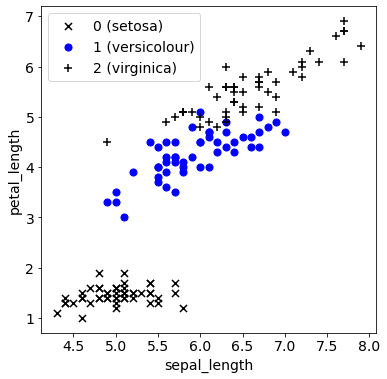

In [217]:
#산점도 표시 
x_t0 = x_select[y_org==0]
x_t1 = x_select[y_org==1]
x_t2 = x_select[y_org==2]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,0],x_t0[:,1],marker='x',c='k',s=50,label='0 (setosa)')
plt.scatter(x_t1[:,0],x_t1[:,1],marker='o',c='b',s=50,label='1 (versicolour)')
plt.scatter(x_t2[:,0],x_t2[:,1],marker='+',c='k',s=50,label='2 (virginica)')
plt.xlabel('sepal_length',fontsize=14)
plt.ylabel('petal_length',fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
print(y_org)

In [218]:
#더미 변수를 추가
x_all=np.insert(x_select, 0 ,1.0,axis=1)

In [219]:
#y의 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
onehotencoder=OneHotEncoder(sparse=False, categories='auto')
# 150*1의 2차원 행렬 
y_work=np.c_[y_org]
# 원핫 벡터 만들기(fit_transform 함수 사용)
y_all_one=onehotencoder.fit_transform(y_work)
print("오리지널",y_org.shape)
print('2차원화',y_work.shape)
print('원핫 인코딩',y_all_one.shape)


오리지널 (150,)
2차원화 (150, 1)
원핫 인코딩 (150, 3)


In [220]:
#학습 데이터와 검증 데이터를 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape,y_train_one.shape, y_test_one.shape)

(75, 3) (75, 3) (75,) (75,) (75, 3) (75, 3)


In [221]:
print('입력 데이터(x)')
print(x_train[:5,:])
print('정답값(y)')
print(y_train[:5])
print('정답값(원핫 인코딩)')
print(y_train_one[:5,:])

입력 데이터(x)
[[1.  6.3 4.7]
 [1.  7.  4.7]
 [1.  5.  1.6]
 [1.  6.4 5.6]
 [1.  6.3 5. ]]
정답값(y)
[1 1 0 2 2]
정답값(원핫 인코딩)
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [222]:
#학습 대상의 선택
x,yt= x_train, y_train_one
print(x.shape)
print(yt.shape)

(75, 3)
(75, 3)


In [223]:
#소프트 맥스 함수
def softmax(x):
    x=x.T #3*75행렬로 변경
    x_max=x.max(axis=0) 
    x=x-x_max #이상치 제거
    w=np.exp(x) 
    return(w/w.sum(axis=0)).T #따로 w의 차수를 생각해줄 이유가없다 왜냐하면 전체 u0+u1+u2값에서 각 열의 총합값으로 나누면 되기때문이다.

In [224]:
#예측값 계산(1단계 75*3 행렬과 3*3가중치 행렬 = 75*3)
def pred(x,W):
  return softmax(x@W)

In [225]:
# 교차 엔트로피 함수 
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))                                                                                   

In [226]:
# 모델을 평가하는 함수
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one, W):
    
    # 학습에 사용되지 않은 검증데이터로 예측값계산
    yp_test_one = pred(x_test, W)
    
    # 확률값에서 예측 클래스(0, 1, 2)를 도출
    yp_test = np.argmax(yp_test_one, axis=1)
    
    # 손실함수 값 계산
    loss = cross_entropy(y_test_one, yp_test_one)
    
    # 정확도 산출
    score = accuracy_score(y_test, yp_test)
    return loss, score

In [227]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N)) 

# 평가 결과 기록
history = np.zeros((0, 3))

In [230]:
# 주요 처리
for k in range(iters):
    
    # 예측값 계산 
    yp = pred(x, W)
    
    # 오차 계산 
    yd = yp - yt

    # 가중치 업데이트 
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history,np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" 
            % (k, loss, score))
        

epoch = 0 loss = 1.092628 score = 0.266667
epoch = 10 loss = 1.064035 score = 0.266667
epoch = 20 loss = 1.033466 score = 0.266667
epoch = 30 loss = 1.002645 score = 0.266667
epoch = 40 loss = 0.973510 score = 0.266667
epoch = 50 loss = 0.946309 score = 0.386667
epoch = 60 loss = 0.920978 score = 0.560000
epoch = 70 loss = 0.897402 score = 0.600000
epoch = 80 loss = 0.875452 score = 0.613333
epoch = 90 loss = 0.855005 score = 0.626667
epoch = 100 loss = 0.835942 score = 0.626667
epoch = 110 loss = 0.818152 score = 0.626667
epoch = 120 loss = 0.801532 score = 0.626667
epoch = 130 loss = 0.785986 score = 0.626667
epoch = 140 loss = 0.771424 score = 0.640000
epoch = 150 loss = 0.757767 score = 0.653333
epoch = 160 loss = 0.744941 score = 0.680000
epoch = 170 loss = 0.732877 score = 0.706667
epoch = 180 loss = 0.721513 score = 0.760000
epoch = 190 loss = 0.710795 score = 0.786667
epoch = 200 loss = 0.700670 score = 0.786667
epoch = 210 loss = 0.691092 score = 0.800000
epoch = 220 loss = 0.

In [233]:
print('[초기] 손실함수: %f, 정확도: %f' %(history[0,1], history[0,2]))
print('[최종] 손실함수: %f, 정확도: %f' %(history[-1,1], history[-1,2]))

[초기] 손실함수: 1.092628, 정확도: 0.266667
[최종] 손실함수: 0.197948, 정확도: 0.960000


Text(0.5, 1.0, 'iter vs loss')

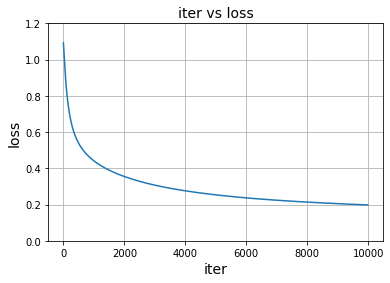

In [241]:
#학습곡선
plt.plot(history[:,0],history[:,1])
plt.grid()
plt.ylim(0,1.2)
plt.xlabel('iter',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.title('iter vs loss', fontsize=14)

Text(0.5, 1.0, 'iter vs accuracy')

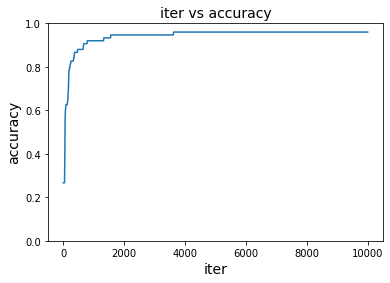

In [245]:
#정밀도
plt.plot(history[:,0],history[:,2])
plt.ylim(0,1)
plt.xlabel('iter',fontsize=14)
plt.ylabel('accuracy',fontsize=14)
plt.title('iter vs accuracy', fontsize=14)

In [251]:
#입력데이터를 4개로 늘린다면?

x_all2=np.insert(x_org,0,1.0,axis=1)
print(x_all2)

[[1.  5.1 3.5 1.4 0.2]
 [1.  4.9 3.  1.4 0.2]
 [1.  4.7 3.2 1.3 0.2]
 [1.  4.6 3.1 1.5 0.2]
 [1.  5.  3.6 1.4 0.2]
 [1.  5.4 3.9 1.7 0.4]
 [1.  4.6 3.4 1.4 0.3]
 [1.  5.  3.4 1.5 0.2]
 [1.  4.4 2.9 1.4 0.2]
 [1.  4.9 3.1 1.5 0.1]
 [1.  5.4 3.7 1.5 0.2]
 [1.  4.8 3.4 1.6 0.2]
 [1.  4.8 3.  1.4 0.1]
 [1.  4.3 3.  1.1 0.1]
 [1.  5.8 4.  1.2 0.2]
 [1.  5.7 4.4 1.5 0.4]
 [1.  5.4 3.9 1.3 0.4]
 [1.  5.1 3.5 1.4 0.3]
 [1.  5.7 3.8 1.7 0.3]
 [1.  5.1 3.8 1.5 0.3]
 [1.  5.4 3.4 1.7 0.2]
 [1.  5.1 3.7 1.5 0.4]
 [1.  4.6 3.6 1.  0.2]
 [1.  5.1 3.3 1.7 0.5]
 [1.  4.8 3.4 1.9 0.2]
 [1.  5.  3.  1.6 0.2]
 [1.  5.  3.4 1.6 0.4]
 [1.  5.2 3.5 1.5 0.2]
 [1.  5.2 3.4 1.4 0.2]
 [1.  4.7 3.2 1.6 0.2]
 [1.  4.8 3.1 1.6 0.2]
 [1.  5.4 3.4 1.5 0.4]
 [1.  5.2 4.1 1.5 0.1]
 [1.  5.5 4.2 1.4 0.2]
 [1.  4.9 3.1 1.5 0.2]
 [1.  5.  3.2 1.2 0.2]
 [1.  5.5 3.5 1.3 0.2]
 [1.  4.9 3.6 1.4 0.1]
 [1.  4.4 3.  1.3 0.2]
 [1.  5.1 3.4 1.5 0.2]
 [1.  5.  3.5 1.3 0.3]
 [1.  4.5 2.3 1.3 0.3]
 [1.  4.4 3.2 1.3 0.2]
 [1.  5.  3

In [254]:
# 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train, y_test,\
y_train_one, y_test_one = train_test_split(
    x_all2, y_org, y_all_one, train_size=75, 
    test_size=75, random_state=123)
print(x_train2.shape, x_test2.shape, 
    y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)



(75, 5) (75, 5) (75,) (75,) (75, 3) (75, 3)


In [255]:
print('입력 데이터(x)')
print(x_train2[:5,:])

입력 데이터(x)
[[1.  6.3 3.3 4.7 1.6]
 [1.  7.  3.2 4.7 1.4]
 [1.  5.  3.  1.6 0.2]
 [1.  6.4 2.8 5.6 2.1]
 [1.  6.3 2.5 5.  1.9]]


In [256]:
# 학습 대상의 선택
x, yt, x_test = x_train2, y_train_one, x_test2

In [257]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N)) 

# 평가 결과 기록
history = np.zeros((0, 3))

In [258]:
for k in range(iters):
    
    # 예측값 계산 
    yp = pred(x, W)
    
    # 오차 계산 (9.7.4)
    yd = yp - yt

    # 가중치 업데이트 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" % (k, loss, score))

epoch = 0 loss = 1.091583 score = 0.266667
epoch = 10 loss = 1.041711 score = 0.266667
epoch = 20 loss = 0.988501 score = 0.266667
epoch = 30 loss = 0.939962 score = 0.573333
epoch = 40 loss = 0.897037 score = 0.626667
epoch = 50 loss = 0.859177 score = 0.626667
epoch = 60 loss = 0.825724 score = 0.626667
epoch = 70 loss = 0.796070 score = 0.626667
epoch = 80 loss = 0.769683 score = 0.653333
epoch = 90 loss = 0.746103 score = 0.653333
epoch = 100 loss = 0.724936 score = 0.693333
epoch = 110 loss = 0.705850 score = 0.746667
epoch = 120 loss = 0.688561 score = 0.760000
epoch = 130 loss = 0.672832 score = 0.760000
epoch = 140 loss = 0.658461 score = 0.786667
epoch = 150 loss = 0.645275 score = 0.786667
epoch = 160 loss = 0.633131 score = 0.786667
epoch = 170 loss = 0.621903 score = 0.813333
epoch = 180 loss = 0.611485 score = 0.813333
epoch = 190 loss = 0.601788 score = 0.840000
epoch = 200 loss = 0.592731 score = 0.840000
epoch = 210 loss = 0.584248 score = 0.880000
epoch = 220 loss = 0.

In [260]:
print ( '[초기] 손실함수: %f, 정확도: %f'
    % (history[0,1], history[0,2]))
print( '[최종] 손실함수: %f, 정확도: %f'
    % (history[-1,1], history[-1,2]))

[초기] 손실함수: 1.091583, 정확도: 0.266667
[최종] 손실함수: 0.137235, 정확도: 0.960000


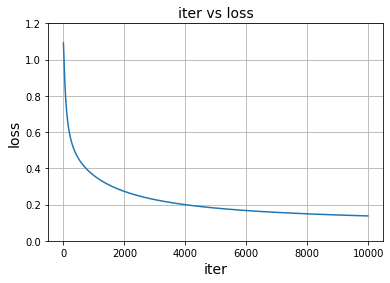

In [261]:
plt.plot(history[:,0], history[:,1])
plt.ylim(0,1.2)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

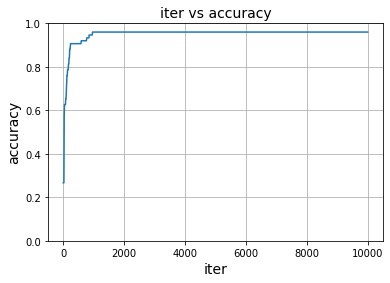

In [263]:
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()